In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import warnings

fontpath = 'C:/Users/TaeSoo/AppData/Local/Microsoft/Windows/Fonts/NanumGothic.ttf'
%matplotlib inline
warnings.filterwarnings(action='ignore')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['xtick.labelsize'] = 6
plt.rc("axes", unicode_minus = False)
pd.options.display.float_format = '{:.5f}'.format

from sklearn.preprocessing import LabelEncoder
from scipy.special import inv_boxcox1p
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, VotingRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import xgboost as xgb

In [7]:
course_df = pd.read_csv('o4_course.csv', index_col = 0)

In [8]:
course_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1753 entries, 0 to 1752
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   main_category      1753 non-null   object 
 1   sub_category       1753 non-null   object 
 2   course_title       1753 non-null   object 
 3   review_score       1315 non-null   float64
 4   review_cnt         1753 non-null   float64
 5   student_cnt        1753 non-null   float64
 6   instructor         1753 non-null   object 
 7   related_tags       1753 non-null   object 
 8   price              1753 non-null   float64
 9   discount_rate      1753 non-null   int64  
 10  sale_price         1753 non-null   float64
 11  limit_time         1753 non-null   object 
 12  certificates       1753 non-null   object 
 13  level              1753 non-null   object 
 14  course_section     1753 non-null   int64  
 15  course_time_index  1753 non-null   object 
 16  course_time_min    1753 

- 종속 변수 : student_cnt

- 카테고리형 변수로 변환 : review_score / answer_period

- 전처리 필요한 변수 : related_tags

- one_hot_encoding : main_category / sub_category / instructor

- label_encoding : certificates / level / limit_time

# 카테고리형 변수로 변환 & Label Encoding

- 'review_score' (리뷰 점수)
    리뷰 점수는 강의에 대한 리뷰 점수가 존재하지 않는 경우, 결측되어 있습니다. 모델링을 위해 결측치 및 그래프 비대칭성에 대한 처리를 위해 카테고리형 변수로 변환합니다. 유사한 데이터 수를 갖도록 구간화를 진행하여 카테고리를 만들고 라벨 인코딩을 진행한 뒤, '리뷰 점수 없음'을 추가합니다.  
#
- 'answer_period' (질문 답변까지 걸리는 기간의 평균) 
    답변 기간도 리뷰 점수와 마찬가지로 질문에 대한 답변이 없는 경우, 결측되어 있습니다. 리뷰 점수와 동일한 과정을 통해 카테고리형 변수로 변환합니다.

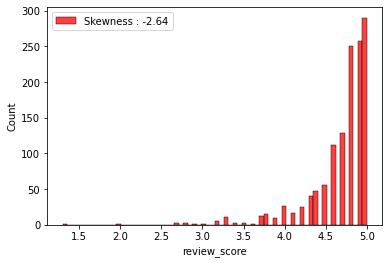

In [10]:
g = sns.histplot(course_df['review_score'], color = 'r', label = 'Skewness : %.2f'%(course_df['review_score'].skew()))
g = g.legend(loc = 'best')

In [11]:
course_df['review_score'] = pd.qcut(course_df['review_score'], 20, duplicates='drop')
course_df['review_score']

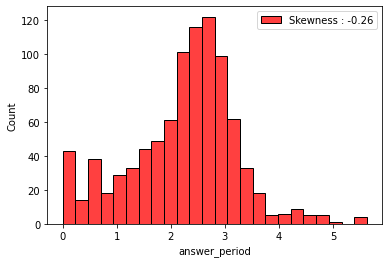

In [13]:
g = sns.histplot(course_df['answer_period'], color = 'r', label = 'Skewness : %.2f'%(course_df['answer_period'].skew()))
g = g.legend(loc = 'best')

In [14]:
course_df['answer_period'] = pd.qcut(course_df['answer_period'], 20, duplicates='drop')
course_df['answer_period']

In [16]:
lbl = LabelEncoder() 

course_df['review_score'] = lbl.fit_transform(list(course_df['review_score'].values)) 
course_df['answer_period'] = lbl.fit_transform(list(course_df['answer_period'].values)) 
# limit_time (수강 기간 제한)은 카테고리형 변수이며 따로 처리할 필요가 없어 라벨 인코딩을 함께 진행함
course_df['limit_time'] = lbl.fit_transform(list(course_df['limit_time'].values))

In [17]:
course_df['review_score'] = course_df['review_score'].apply(lambda x : x + 1)
course_df['review_score'] = course_df['review_score'].replace(10, 1)

기존의 카테고리형 변수인 'certificates'와 'level'은 값에 따라 순서에 맞게 라벨 인코딩이 필요하여 아래와 같이 진행하였습니다.

In [18]:
course_df['certificates'] = course_df['certificates'].apply(lambda x : 1 if x == '발급' else 0)
course_df['level'] = course_df['level'].apply(lambda x : 1 if x == '입문' else 2 if x == '초급' else 3)

# one-hot-encoding

- 'related_tags' (강의 관련 태그)
    강의 관련 태그는 값의 순서가 존재하지 않으므로 one-hot-encoding을 진행합니다. 
    1. 분석에 용이하도록 문자열을 전처리합니다.
    2. 강의에 존재하는 모든 태그 정보를 추출하여 변수로 추가합니다.
    3. 강의마다 태그를 추출하여 변수(강의 관련 태그)와 동일한 경우, 1로 표시하고 나머지는 0으로 표시합니다.
    

In [18]:
course_df['related_tags'] = course_df['related_tags'].str.replace('[', '', regex = True)
course_df['related_tags'] = course_df['related_tags'].str.replace("'", '', regex = True)
course_df['related_tags'] = course_df['related_tags'].str.replace(']', '', regex = True)
course_df['related_tags'] = course_df['related_tags'].str.replace('출간,', '출간')

In [21]:
tag_list = []

for index in range(len(course_df)) :
    for element in range(len(course_df['related_tags'].str.split(',')[index])) :
        if course_df['related_tags'].str.split(', ')[index][element] not in tag_list :
            tag_list.append(course_df['related_tags'].str.split(', ')[index][element])

In [22]:
for tag in tag_list :
    course_df[tag] = 0

In [36]:
for index in range(len(course_df)) :
    for element in range(len(course_df['related_tags'].str.split(',')[index])) :
        for tag in tag_list :
            if course_df['related_tags'].str.split(', ')[index][element] == tag :
                course_df[tag][index] += 1

In [20]:
course_df.to_csv('o5_course.csv', encoding = 'utf-8-sig')

In [3]:
course_df = pd.read_csv('o5_course.csv', index_col = 0)

In [4]:
course_df.drop(columns = 'course_title', inplace = True)
course_df.drop(columns = 'related_tags', inplace = True)
course_df.drop(columns = 'course_time_index', inplace = True)

전처리가 필요없는 'main_category', 'sub_category', 'instructor'는 바로 one_hot_encoding을 진행하였습니다.

In [5]:
one_hot_features = ['main_category', 'sub_category', 'instructor']

course_df = pd.get_dummies(course_df, columns = one_hot_features)

# 모델링

모델링은 아래의 6개의 모델을 이용하여 학습을 진행하였습니다.  

- Ridge
- Lasso
- ElasticNet
- RandomForest
- GradientBoosting
- XGBoosting

모델들은 RMSE를 통해 예측 성능을 비교하였습니다.

1. 초매개변수 조정 없이 데이터 학습 및 성능 비교
2. 초매개변수 조정 이후 데이터 학습 및 성능 비교

In [6]:
data = course_df.drop(columns = 'student_cnt')
target = course_df['student_cnt']

random_state = 14
kfold = KFold(n_splits = 5,  shuffle = True).get_n_splits(data.values)

      Algorithm  cv_means  cv_std
0         Ridge   1.08362 0.04744
1         Lasso   2.44174 0.54583
2    ElasticNet   2.44174 0.54583
3  RandomForest   0.60265 0.06056
4            Gb   0.59235 0.05012
5           Xgb   0.57910 0.07215


Text(0.5, 0, 'RMSE')

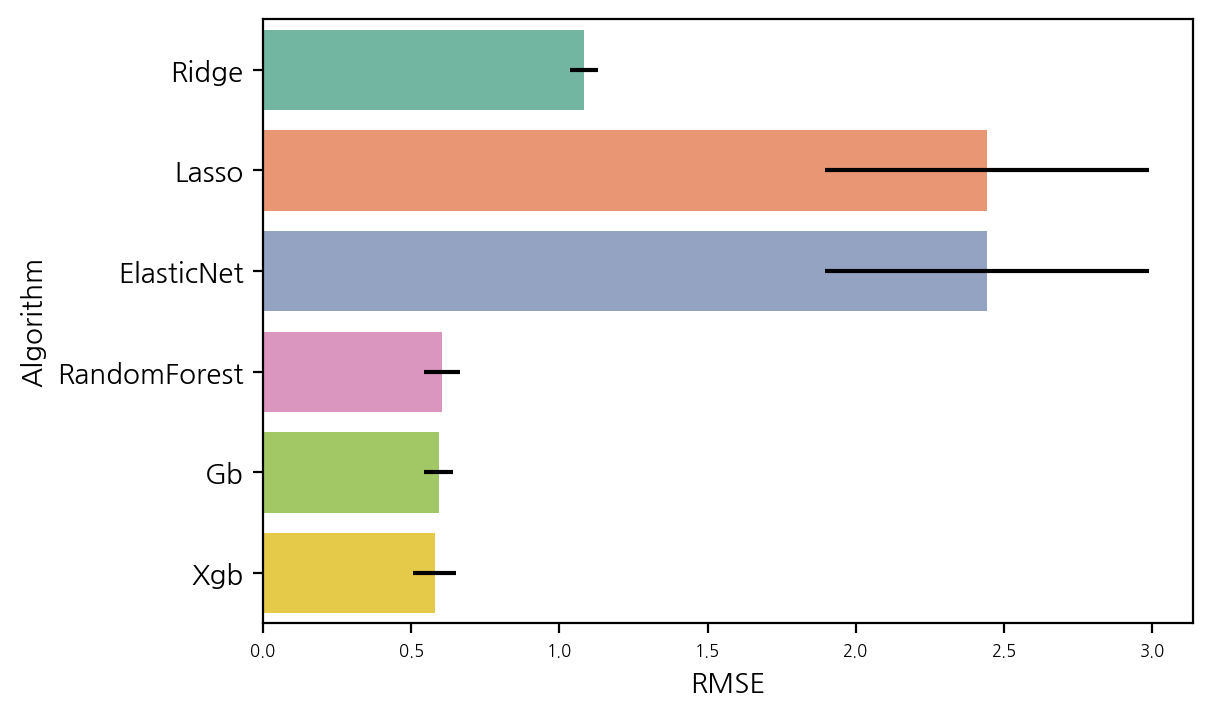

In [89]:
regressifiers = []
regressifiers.append(Ridge(normalize = True, random_state = random_state)) 
regressifiers.append(Lasso(normalize = True, random_state = random_state)) 
regressifiers.append(ElasticNet(normalize = True, random_state = random_state)) 
regressifiers.append(RandomForestRegressor(random_state = random_state)) 
regressifiers.append(GradientBoostingRegressor(random_state = random_state)) 
regressifiers.append(xgb.XGBRegressor(random_state = random_state)) 

cv_results = []
for regressifier in regressifiers :
    cv_results.append(np.sqrt(-cross_val_score(regressifier, data.values, np.ravel(target), scoring = 'neg_mean_squared_error', cv = kfold)))

cv_means = []
cv_std = []
for cv_result in cv_results :
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({'Algorithm' : ['Ridge', 'Lasso', 'ElasticNet', 'RandomForest', 'Gb', 'Xgb'],
                        'cv_means' : cv_means,
                        'cv_std' : cv_std})

print(cv_res)
g = sns.barplot('cv_means', 'Algorithm', data = cv_res, palette = 'Set2', orient = "h",**{'xerr':cv_std})
plt.xlabel('RMSE')

# 초매개변수 튜닝

각 모델에 대해 초매개변수를 튜닝하여 모델들이 더욱 적합하게 학습할 수 있도록 진행하였습니다.

- 'Ridge', 'Lasso', 'ElasticNet'은 알파 값만 조정하여 튜닝하였습니다.
    알파 값은 계수가 큰 몇 개의 변수에 따라 모델의 학습에 부정적인 영향을 줄 수 있으므로 변수들의 계수를 조정하는 역할을 합니다.
    'kfold'를 이용해 교차검증하여 overfitting을 방지하였으며 'GridSearchCV'를 통해 최적의 하이퍼파라미터 값을 추적하였습니다.
#
- 'RandomForest'와 'GradientBoosting' 모델은 초매개변수 튜닝을 하지 않는 모델이 더 좋은 성능을 보여 튜닝을 진행하지 않았습니다. 'n_estimators'를 통해 모델을 생성할 때 데이터 셋을 조금씩 변형하여 overfitting을 방지하였습니다.
#
- 'XGBoosting'는 모델이 트리를 생성할 때 약간의 가중치 및 트리의 깊이를 제한하여 overfitting을 방지하면서 최적의 학습을 진행 할 수 있도록 여러 초매개변수를 튜닝하였습니다. 

In [51]:
ridge = Ridge(normalize = True, random_state = random_state)

ridge_param_grid = {'alpha':  [0.1, 0.2, 0.3, 0.4, 0.5]}
gsRidge = GridSearchCV(estimator = ridge, param_grid = ridge_param_grid, cv = kfold, scoring = 'neg_mean_squared_error', verbose = 1)
gsRidge.fit(data, np.ravel(target))
ridge_estimator = gsRidge.best_estimator_
ridge_score = np.sqrt(-gsRidge.best_score_)

print("\nRidge : {0} / {1}\n".format(ridge_estimator, ridge_score))

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Ridge : Ridge(alpha=0.1, normalize=True, random_state=14) / 0.8238585448272762



In [52]:
lasso = Lasso(normalize = True, random_state = random_state)

lasso_param_grid = {'alpha':  [0.0001, 0.001, 0.01, 0.1]}
gsLasso = GridSearchCV(estimator = lasso, param_grid = lasso_param_grid, cv = kfold, scoring = 'neg_mean_squared_error', verbose = 1)
gsLasso.fit(data, np.ravel(target))
lasso_estimator = gsLasso.best_estimator_
lasso_score = np.sqrt(-gsLasso.best_score_)

print("\nLasso : {0} / {1}\n".format(lasso_estimator, lasso_score))

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Lasso : Lasso(alpha=0.0001, normalize=True, random_state=14) / 0.774288695104477



In [53]:
en = ElasticNet(normalize = True, random_state = random_state)

en_param_grid = {'alpha':  [0.0001, 0.001, 0.01, 0.1]}
gsEN = GridSearchCV(estimator = en, param_grid = en_param_grid, cv = kfold, scoring = 'neg_mean_squared_error', verbose = 1)
gsEN.fit(data, np.ravel(target))
en_estimator = gsEN.best_estimator_
en_score = np.sqrt(-gsEN.best_score_)

print("\nElasticNet : {0} / {1}\n".format(en_estimator, en_score))

Fitting 5 folds for each of 4 candidates, totalling 20 fits

ElasticNet : ElasticNet(alpha=0.0001, normalize=True, random_state=14) / 0.7826577931392185



In [54]:
rf = RandomForestRegressor(random_state = random_state)
rf_param_grid = {'n_estimators' :[500]}
gsRF = GridSearchCV(estimator = rf, param_grid = rf_param_grid, cv = kfold, scoring = 'neg_mean_squared_error', verbose = 1)
gsRF.fit(data, np.ravel(target))
rf_estimator = gsRF.best_estimator_
rf_score = np.sqrt(-gsRF.best_score_)

print("\nRandomForest : {0} / {1}\n".format(rf_estimator, rf_score))

Fitting 5 folds for each of 1 candidates, totalling 5 fits

RandomForest : RandomForestRegressor(n_estimators=500, random_state=14) / 0.6037263062658214



In [55]:
gb = GradientBoostingRegressor(random_state = random_state)

gb_param_grid = {'n_estimators' : [500]}
gsGB = GridSearchCV(estimator = gb, param_grid = gb_param_grid, cv = kfold, scoring = 'neg_mean_squared_error', verbose = 1)
gsGB.fit(data, np.ravel(target))
gb_estimator = gsGB.best_estimator_
gb_score = np.sqrt(-gsGB.best_score_)

print("\nGradientBoosting : {0} / {1}\n".format(gb_estimator, gb_score))

Fitting 5 folds for each of 1 candidates, totalling 5 fits

GradientBoosting : GradientBoostingRegressor(n_estimators=500, random_state=14) / 0.5711906667768201



In [59]:
xgb = xgb.XGBRegressor(random_state = random_state)

xgb_param_grid = {'max_depth' : [3],
                  'min_child_weight' : [0.001],
                  'colsample_bytree' : [1],
                  'subsample' : [0.8],
                  'gamma' : [0.01],
                  'lambda' : [0.5],
                  'alpha' : [0.01],
                  'learning_rate' : [0.1],
                  'n_estimators' : [500],
                  'eval_metric' : ['rmse']}
gsXGB = GridSearchCV(estimator = xgb, param_grid = xgb_param_grid, cv = kfold, scoring = 'neg_mean_squared_error', verbose = 1)
gsXGB.fit(data, np.ravel(target))
xgb_estimator = gsXGB.best_estimator_
xgb_score = np.sqrt(-gsXGB.best_score_)

print("\nXGB : {0} / {1}\n".format(xgb_estimator, xgb_score))

Fitting 5 folds for each of 1 candidates, totalling 5 fits

XGB : XGBRegressor(alpha=0.01, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='rmse', gamma=0.01, gpu_id=-1, importance_type=None,
             interaction_constraints='', lambda=0.5, learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=0.001, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=14,
             reg_alpha=0.00999999978, reg_lambda=0.5, scale_pos_weight=1,
             subsample=0.8, tree_method='exact', validate_parameters=1, ...) / 0.5585555816725948



      Algorithm  h_cv_means  h_cv_std
0         Ridge     0.81856   0.09331
1         Lasso     0.76920   0.08862
2    ElasticNet     0.77760   0.08884
3  RandomForest     0.60062   0.06115
4            Gb     0.56844   0.05604
5           Xgb     0.55512   0.06188


Text(0.5, 0, 'RMSE')

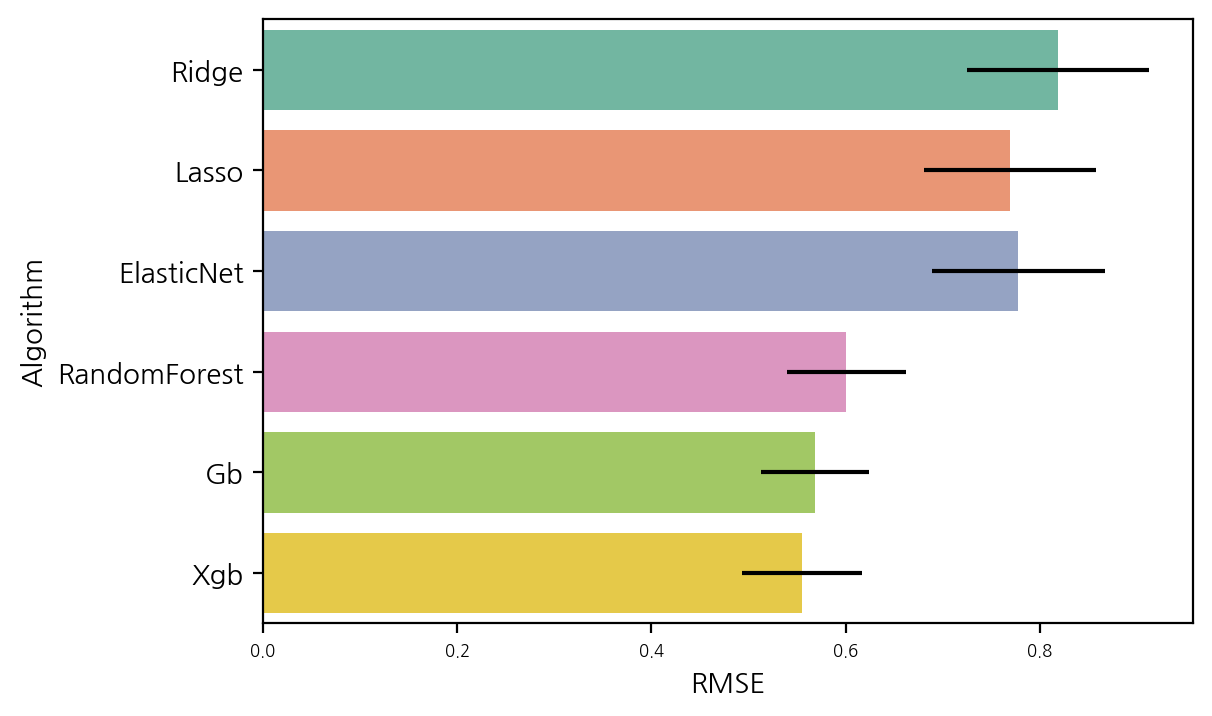

In [66]:
h_regressifiers = []
h_regressifiers.append(gsRidge.best_estimator_) 
h_regressifiers.append(gsLasso.best_estimator_) 
h_regressifiers.append(gsEN.best_estimator_)
h_regressifiers.append(gsRF.best_estimator_) 
h_regressifiers.append(gsGB.best_estimator_) 
h_regressifiers.append(gsXGB.best_estimator_)

h_cv_results = []
for h_regressifier in h_regressifiers :
    h_cv_results.append(np.sqrt(-cross_val_score(h_regressifier, data.values, np.ravel(target), scoring = 'neg_mean_squared_error', cv = kfold)))

h_cv_means = []
h_cv_std = []
for h_cv_result in h_cv_results :
    h_cv_means.append(h_cv_result.mean())
    h_cv_std.append(h_cv_result.std())
    
cv_res = pd.DataFrame({'Algorithm' : ['Ridge', 'Lasso', 'ElasticNet', 'RandomForest', 'Gb', 'Xgb'],
                        'h_cv_means' : h_cv_means,
                        'h_cv_std' : h_cv_std})

print(cv_res)
g = sns.barplot('h_cv_means', 'Algorithm', data = cv_res, palette = 'Set2', orient = "h",**{'xerr':h_cv_std})
plt.xlabel('RMSE')

# 변수 중요도 분석

초매개변수를 튜닝한 3개의 모델('RandomForest', 'GradientBoosting', 'XGBoosting')을 통해 변수들의 중요도를 분석하였습니다.

수강생 수를 예측하기 위한 변수 중요도 분석 인사이트는 다음과 같습니다.

1. 할인 가격이 수강생 수 예측에 가장 큰 영향을 미친다.
2. 수료증 발급 유무 / 강의 총 시간 / 수강 제한 기간 등도 영향을 미쳤다.
3. 여러 강의를 서비스하는 강사의 경우, 수강생 수 예측에 중요 지표로 사용되었다.

In [ ]:
def clf(x, y):
    # random forest
    rf = rf_estimator
    rf.fit(x, y)
    result_rf = permutation_importance(rf, x,y , n_repeats=10, random_state = 14)
    sorted_idx_rf = result_rf.importances_mean.argsort()
    importances_rf = pd.DataFrame(result_rf.importances_mean[sorted_idx_rf], index=x.columns[sorted_idx_rf], columns = ['feature_importance']).sort_values(0, ascending=False)
    
    # gradient boosting
    gb = gb_estimator
    gb.fit(x, y)
    result_gb = permutation_importance(gb, x,y , n_repeats=10, random_state = 14)
    sorted_idx_gb = result_gb.importances_mean.argsort()
    importances_gb = pd.DataFrame(result_gb.importances_mean[sorted_idx_gb], index=x.columns[sorted_idx_gb], columns = ['feature_importance']).sort_values(0, ascending=False)
    
    # xg boosting
    xgb = xgb_estimator
    xgb.fit(x, y)
    result_xgb = permutation_importance(xgb, x,y , n_repeats=10, random_state = 14)
    sorted_idx_xgb = result_xgb.importances_mean.argsort()
    importances_xgb = pd.DataFrame(result_xgb.importances_mean[sorted_idx_xgb], index=x.columns[sorted_idx_xgb], columns = ['feature_importance']).sort_values(0, ascending=False)
    
    return importances_rf, importances_gb, importances_xgb

In [ ]:
importances_rf, importances_gb, importances_xgb = clf(data, target)

importances_rf.to_csv('importances_rf.csv', encoding = 'utf-8-sig')
importances_gb.to_csv('importances_gb.csv', encoding = 'utf-8-sig')
importances_xgb.to_csv('importances_xgb.csv', encoding = 'utf-8-sig')

In [48]:
importances_rf[:10]

,feature_importance
sale_price,1.25518
review_cnt,0.58733
certificates,0.04869
discount_rate,0.03944
price,0.03040
course_time_min,0.02172
total_question,0.02106
limit_time,0.00886
course_section,0.00869
main_category_개발 · 프로그래밍,0.00816


In [49]:
importances_gb[:10]

,feature_importance
sale_price,1.08163
review_cnt,0.52680
certificates,0.05135
discount_rate,0.01935
course_time_min,0.01560
total_question,0.01276
price,0.01184
instructor_인프런,0.00852
instructor_유용한IT학습,0.00503
limit_time,0.00337


In [50]:
importances_xgb[:10]

,feature_importance
sale_price,1.36869
review_cnt,0.49176
price,0.20085
course_time_min,0.01860
total_question,0.01269
instructor_인프런,0.00985
discount_rate,0.00488
instructor_유용한IT학습,0.00441
limit_time,0.00334
instructor_마소캠퍼스,0.00330


# 앙상블

하이퍼 파라미터를 조정한 모델들을 앙상블하여 최종적으로 강의마다 수강생 수를 예측합니다.  
앙상블 방법 중에서 보팅과 스태킹을 사용하여 예측하고 더 나은 앙상블 모델을 찾습니다.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, shuffle = True, random_state = 14)

In [81]:
votingR = VotingRegressor(estimators = [('rf', rf_estimator), ('gb', gb_estimator), 
('xgb', xgb_estimator)])

votingR.fit(X_train.values, np.ravel(y_train))
votingR_train_pred = votingR.predict(X_train.values) 
votingR_pred = votingR.predict(X_test.values)

In [120]:
class StackingAveragedModels (BaseEstimator, RegressorMixin, TransformerMixin) :
    def __init__(self, base_models, meta_model) :
        self.base_models = base_models
        self.meta_model = meta_model
    
    def fit (self, X, y) :
        self.base_models_ = [list() for i in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits = 10,  shuffle = True, random_state = random_state)
        
        train_fold_predict = np.zeros((X.shape[0],len(self.base_models)))
        
        for i, model in enumerate (self.base_models) :
            for train_index, valid_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                test_predict = instance.predict(X[valid_index])
                train_fold_predict[valid_index, i] = test_predict
        
        self.meta_model_.fit(train_fold_predict, y)
        return self
    
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [123]:
stacked_model = StackingAveragedModels(base_models = (rf_estimator, gb_estimator, xgb_estimator),
                                                 meta_model = lasso_estimator)

stacked_model.fit(X_train.values, np.ravel(y_train))
stacked_train_pred = stacked_model.predict(X_train.values) 
stacked_pred = stacked_model.predict(X_test.values)

In [124]:
result = pd.DataFrame()
result['value'] = np.ravel(y_test)
result['v_pred'] = votingR_pred
result['s_pred'] = stacked_pred

In [125]:
result['value'] = inv_boxcox1p(result['value'], 0.001)
result['v_pred'] = inv_boxcox1p(result['v_pred'], 0.001)
result['s_pred'] = inv_boxcox1p(result['s_pred'], 0.001)

result = result.round(0)
result = result.astype(int)
result = result.sort_values('value')

- 두 앙상블 모델의 RMSE 점수를 기준으로 비교하였습니다. 
train data와 test data를 비교하였을 때, 두 모델은 약간의 overfitting이 있었지만 앙상블 전보다 수강생 수(종속 변인)을 더 잘 예측하였습니다.

- 보팅 모델은 train data에서 더 잘 예측하였으나 test 데이터와의 편차가 비교적 크고 스태킹 모델의 경우, 조금 더 잘 학습된 모델이라는 것을 알 수 있었습니다.

In [133]:
print(np.sqrt(mean_squared_error(y_train, votingR_train_pred)))
print(np.sqrt(mean_squared_error(y_train, stacked_train_pred)))
print(np.sqrt(mean_squared_error(y_test, votingR_pred)))
print(np.sqrt(mean_squared_error(y_test, stacked_pred)))


0.258633641246257
0.2891630877240816
0.494087313560501
0.48295991217653944


In [8]:
result.to_csv('student_pred.csv')

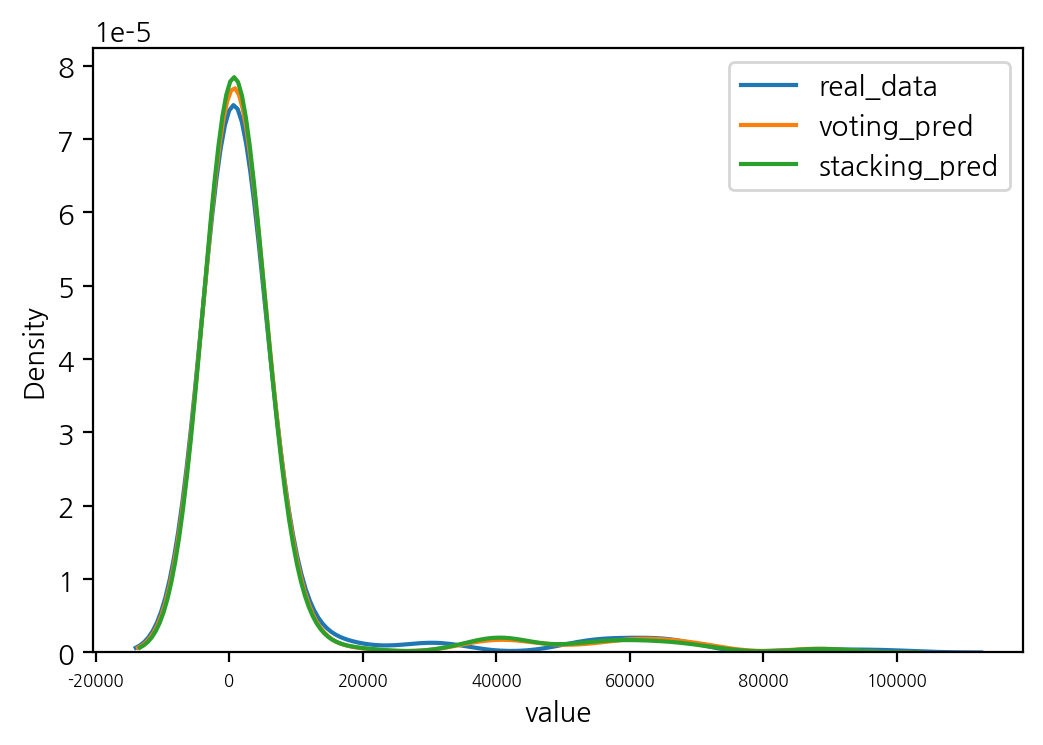

In [10]:
sns.kdeplot(result['value'], shade=False, label = 'real_data')
sns.kdeplot(result['v_pred'], shade=False, label = 'voting_pred')
sns.kdeplot(result['s_pred'], shade=False, label = 'stacking_pred')
plt.legend()

커널밀도추정 시각화로는 예측값과 실제값의 차이를 파악하기 어렵습니다.

오차를 시각화하기위해 오차율을 계산하여 아래와 같이 시각화를 진행하였습니다.  
수강생 수가 적은 강의는 상대적으로 예측이 더 어려웠습니다.

변수 중요도 분석 및 수강생 수 예측 모델 생성 등을 더 정확하게 하기 위해서는 좋은 질의 데이터들을 추가하여야 할 것으로 보입니다.

In [11]:
result['v_error'] = (result['value'] - result['v_pred']) / result['value'] *100
result['s_error'] = (result['value'] - result['s_pred']) / result['value'] *100

Text(0, 0.5, 'error rate')

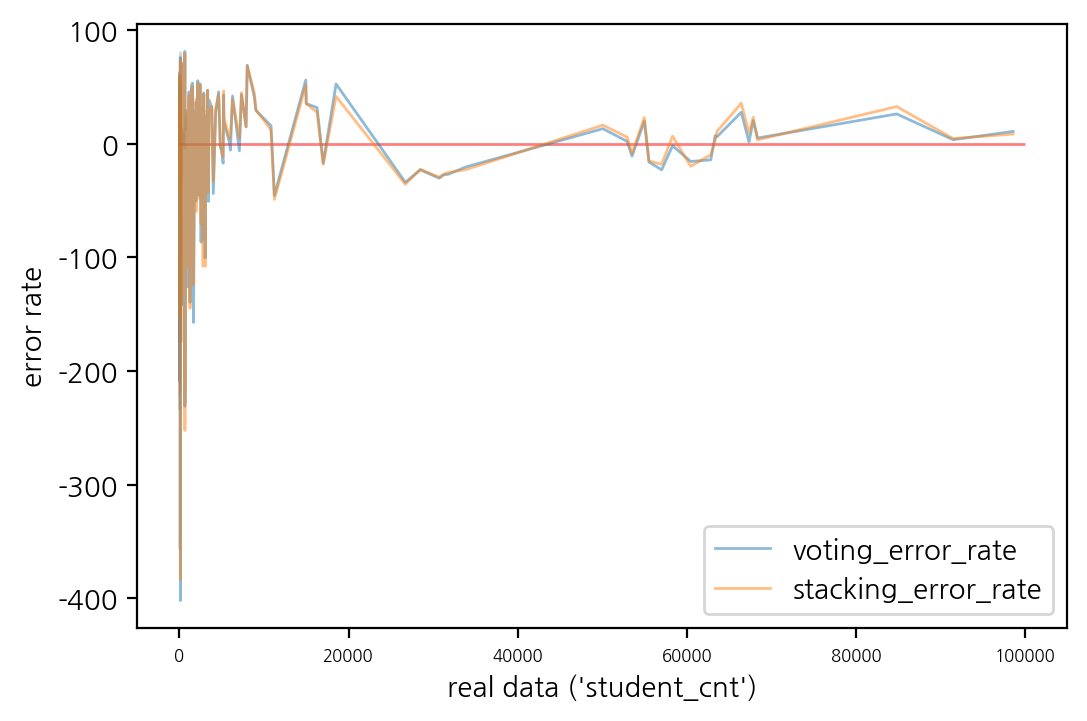

In [14]:
sns.lineplot(x = 'value', y = 'v_error', data = result, linewidth=1, alpha  = 0.5, label = 'voting_error_rate')
sns.lineplot(x = 'value', y = 's_error', data = result, linewidth=1, alpha  = 0.5, label = 'stacking_error_rate')
plt.hlines(0,0,100000, color='r', linewidth=1, alpha  = 0.5)

plt.xlabel("real data ('student_cnt')")
plt.ylabel('error rate')